# Lung Adenocarcinoma Segmentation with the WSSS4LUAD dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


MessageError: ignored

## Imports and Downloads

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install tiatoolbox seaborn | tail -n 1
ON_GPU=False
print('Installation is done.')
!pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True 
!pip install seaborn
!pip install Pillow==9.0.0
!pip install validators matplotlib
!pip install torch-summary
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
!pip install captum

Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Installation is done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
     |████████████████████████████████| 831.4 MB 6.4 kB/s 
     |████████████████████████████████| 22.1 MB 42 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.9.1+cu102 which is incompatible.
torchaudio 0.12.0+cu113 requires torch==1.12.0, but you have torch 1.9.1+cu102 which is incompatible.
tiatoolbox 1.2.1 requires torch>=1.11.0, but you have torch 1.9.1+cu102 which is incompatible.
tiatoolbox 1.2.1 requires torchvision>=0.12.0, but you have torchvision 0.10.1+cu102 which is incompatibl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=32a658e216b76161829c81e6469d72ba28368939c883b0a43a0983f7bd2aa658
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.7 MB/s 


In [ ]:
import tables
import cv2
from PIL import Image
from random import randint 
import torchvision
import tables as pt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import torch.nn.functional as P
import random

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
import numpy as np
from tiatoolbox.tools import patchextraction
import time
import os
import copy
from sklearn.metrics import cohen_kappa_score,precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
import pickle
import PIL 
from torchsummary import summary
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
)
import math
from tqdm import tqdm

from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
from google.colab.patches import cv2_imshow
from skimage.morphology import reconstruction
from tiatoolbox.tools.tissuemask import MorphologicalMasker
plt.style.use('seaborn')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Directories, and Simple Data Cleaning


In [ ]:
img_dtype = tables.UInt8Atom()  # dtype in which the images will be saved, this indicates that images will be saved as unsigned int 8 bit, i.e., [0,255]
filenameAtom = tables.StringAtom(itemsize=255) #create an atom to store the filename of the image, just incase we need it later, 
training_directory = '/content/drive/MyDrive/1.training/1.training/'
validation_directory = '/content/drive/MyDrive/2.validation/2.validation/'
testing_directory = '/content/drive/MyDrive/3.testing/3.testing/'


In [ ]:
#Match the ground truth to the training image
X_image_strings = list()
training_y = list()

for image_string in os.listdir(training_directory):
  X_image_strings.append(os.path.join(training_directory,image_string))
  new_string = image_string[-13:-4].strip()
  new_label= [int(new_string[-8]),int(new_string[-5]),int(new_string[-2])]
  training_y.append(np.array(new_label))

## training and validation cleaning

In [ ]:
def get_padding(image):
    max_w = 240    
    max_h = 240
    
    imsize = image.shape[1],image.shape[0]
    #imsize = image.size

    h_padding = (max_w - imsize[0]) / 2
    v_padding = (max_h - imsize[1]) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    
    padding = (int(t_pad), int(b_pad), int(l_pad), int(r_pad))
    
    return padding


In [ ]:
train_X_natural_numpy = list()
for image in os.listdir(training_directory):
  
  io=cv2.cvtColor(cv2.imread(training_directory+image),cv2.COLOR_BGR2RGB)
  interp_method=PIL.Image.BICUBIC
  io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
  io = cv2.resize(io,(224,224))
  train_X_natural_numpy.append(io)

In [ ]:
train_X_natural_numpy = list()
for image in os.listdir(training_directory):
  
  io=cv2.cvtColor(cv2.imread(training_directory+image),cv2.COLOR_BGR2RGB)
  interp_method=PIL.Image.BICUBIC
  io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
  #print(np.subtract(shape,io.shape))
  if io.shape[0]<=240 and io.shape[1]<=240:
    all_padding = get_padding(io)
    io = np.pad(io, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
    train_X_natural_numpy.append(io)
  else:
    io = cv2.resize(io,(240,240))
    train_X_natural_numpy.append(io)
    

In [ ]:
#Match the ground truth to the training image
X_image_strings_valid = list()
y_valid_strings = list()

for image_string in os.listdir(validation_directory+'/img'):
    X_image_strings_valid.append(os.path.join(validation_directory+'img',image_string))
for image_string in os.listdir(validation_directory+'/mask'):
    y_valid_strings.append(os.path.join(validation_directory+'mask',image_string))


In [ ]:
validation_data = {
    'larger_images'  : dict(),
    'smaller_images' : dict()
}

In [ ]:
def sort_data(file_loc_data, data_dictionary,directory):
  # Sort validation data 
  for i in range(len(file_loc_data)):
    # We need to sort if the image is large or not
    
    io=cv2.cvtColor(cv2.imread(file_loc_data[i]),cv2.COLOR_BGR2RGB)
    io_mask = cv2.cvtColor(cv2.imread(directory+'/mask'+file_loc_data[i][-7:]),cv2.COLOR_BGR2RGB)
    count = 0 
    interp_method=PIL.Image.BICUBIC
    io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
    io_mask = cv2.resize(io_mask,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above

    # If its a small image we want to pad and add to the smaller images 
    if io.shape[0] <= 240 and io.shape[1]<= 240:
      io_mask_map = map(int,[(io_mask == (0,64,128)).all(axis=-1).max(), (io_mask == (64,128,0)).all(axis=-1).max(), (io_mask == (243,152,0)).all(axis=-1).max()])
      io_mask_y_int = list(io_mask_map)
      all_padding = get_padding(io)
      io = np.pad(io, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
      io_mask = np.pad(io_mask, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
      data_dictionary['smaller_images'][file_loc_data[i][-6:]] = {'patch':io, 'mask':io_mask, 'label':io_mask_y_int} 
    else:
      # Create patches within the larger images
      patch_list = list()
      patch_list_mask = list()
      patch_y_values = list()
      sliding_window_patch_extractor = patchextraction.SlidingWindowPatchExtractor(
          input_img=io, # input image path, numpy array, or WSI object
          patch_size=(240, 240),
          input_mask = None,
       
      )
    
      
      sliding_window_patch_extractor_mask = patchextraction.SlidingWindowPatchExtractor(
          input_img=io_mask, # input image path, numpy array, or WSI object
          patch_size=(240, 240),
          input_mask = None,
          
      )

      for patch in sliding_window_patch_extractor:
        patch_list.append(patch)

      for patch_mask in sliding_window_patch_extractor_mask:
        io_mask_map = map(int,[(patch_mask == (0,64,128)).all(axis=-1).max(), (patch_mask == (64,128,0)).all(axis=-1).max(), (patch_mask == (243,152,0)).all(axis=-1).max()])
        io_mask_y_int = list(io_mask_map)
        patch_y_values.append(io_mask_y_int)
        patch_list_mask.append(patch_mask)
      print(patch_y_values)
      data_dictionary['larger_images'][file_loc_data[i][-6:]] = {'patches':patch_list, 'masks':patch_list_mask, 'labels':patch_y_values} 

  return data_dictionary

In [ ]:
# 224 x 224 
def sort_data(file_loc_data, data_dictionary,directory):
  # Sort validation data 
  for i in range(len(file_loc_data)):
    # We need to sort if the image is large or not
    
    io=cv2.cvtColor(cv2.imread(file_loc_data[i]),cv2.COLOR_BGR2RGB)
    io_mask = cv2.cvtColor(cv2.imread(directory+'/mask'+file_loc_data[i][-7:]),cv2.COLOR_BGR2RGB)
    count = 0 
    interp_method=PIL.Image.BICUBIC
    io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
    io_mask = cv2.resize(io_mask,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above

    # If its a small image we want to pad and add to the smaller images 
    if io.shape[0] <= 224 and io.shape[1]<= 224:
      io_mask_map = map(int,[(io_mask == (0,64,128)).all(axis=-1).max(), (io_mask == (64,128,0)).all(axis=-1).max(), (io_mask == (243,152,0)).all(axis=-1).max()])
      io_mask_y_int = list(io_mask_map)
      #io_mask_map
      io = cv2.resize(io,(224,224))
      io_mask = cv2.resize(io_mask,(224,224))
      #all_padding = get_padding(io)
      #io = np.pad(io, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
      #io_mask = np.pad(io_mask, pad_width=((all_padding[0], all_padding[1]), (all_padding[2], all_padding[3]),(0,0)))
      data_dictionary['smaller_images'][file_loc_data[i][-6:]] = {'patch':io, 'mask':io_mask, 'label':io_mask_y_int} 
    else:
      # Create patches within the larger images
      patch_list = list()
      patch_list_mask = list()
      patch_y_values = list()
      #print(file_loc_data[i])
      sliding_window_patch_extractor = patchextraction.SlidingWindowPatchExtractor(
          input_img=io, # input image path, numpy array, or WSI object
          patch_size=(224, 224),
          input_mask = None,
          # also supports "point" and "slidingwindow"
          # size of the patch to extract around the centroids from centroids_list
      )
    
      
      sliding_window_patch_extractor_mask = patchextraction.SlidingWindowPatchExtractor(
          input_img=io_mask, # input image path, numpy array, or WSI object
          patch_size=(224, 224),
          input_mask = None,
          # also supports "point" and "slidingwindow"
          # size of the patch to extract around the centroids from centroids_list
          # stride of extracting patches, default is equal to patch_size
      )

      for patch in sliding_window_patch_extractor:
        patch_list.append(patch)

      for patch_mask in sliding_window_patch_extractor_mask:
        io_mask_map = map(int,[(patch_mask == (0,64,128)).all(axis=-1).max(), (patch_mask == (64,128,0)).all(axis=-1).max(), (patch_mask == (243,152,0)).all(axis=-1).max()])
        io_mask_y_int = list(io_mask_map)
        patch_y_values.append(io_mask_y_int)
        patch_list_mask.append(patch_mask)
      print(patch_y_values)
      data_dictionary['larger_images'][file_loc_data[i][-6:]] = {'patches':patch_list, 'masks':patch_list_mask, 'labels':patch_y_values} 

  return data_dictionary

In [ ]:
validation_data = sort_data(X_image_strings_valid,validation_data, validation_directory)

[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 0]]
[[0, 0, 1], [0, 0, 1]]
[[1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 0, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 0, 0]]
[[1, 0, 1], [1, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
[[0, 1, 1], [0, 0, 1], [1, 1, 1], [0, 1, 1]]
[[1, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [0, 1, 0]]
[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0]]
[[1, 1, 0], [0, 1, 0], [1, 1, 0], [0, 0, 0]]
[[1, 1, 0], [1, 1, 0], [0, 1, 0], [1, 1, 0], [0

In [ ]:
validation_X_data = list()
validation_y_data = list()
validation_mask_data = list()

for key,item_dict in validation_data['smaller_images'].items():
  validation_X_data.append(item_dict['patch'])
  validation_y_data.append(item_dict['label'])
  validation_mask_data.append(item_dict['mask'])


for key,item_dict in validation_data['larger_images'].items():
  for i in range(len(item_dict['patches'])):
    validation_X_data.append(item_dict['patches'][i])
    validation_y_data.append(item_dict['labels'][i])
    validation_mask_data.append(item_dict['masks'][i])

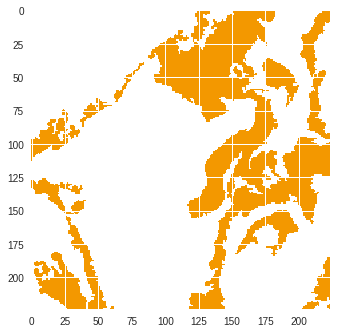

In [ ]:
plt.imshow(validation_mask_data[0])

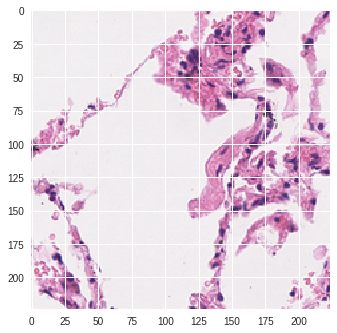

In [ ]:
plt.imshow(validation_X_data[0])

In [ ]:
# Create training dataset for multi-label classification
class WSSS4LUAD_train(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(train_X_natural_numpy)
    self.labels = np.array(training_y)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = torch.tensor(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return {'image' : image,
            'label' : label}
  
  def __len__(self):
    return self.n_samples


# Create training dataset for multi-label classification
class WSSS4LUAD_validation(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(validation_X_data)
    self.labels = np.array(validation_y_data)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = torch.tensor(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return {'image' : image,
            'label' : label}
  
  def __len__(self):
    return self.n_samples



In [ ]:
# start the training and validation

def full_training_and_val_seg(backbone_model):
  #luad_model = luad_model.to(device)
  criterion = nn.CrossEntropyLoss(reduce=False)

  optimizer = torch.optim.Adam(backbone_model.parameters()) # Adam is going to be the most robust
  epochs = 5
  train_loss = []
  valid_loss = []
  valid_matrices = []
  best_loss = float('inf')
  for epoch in range(epochs):
      print(f"Epoch {epoch+1} of {epochs}")
      train_epoch_loss = seg_train(
          backbone_model, optimizer, criterion, 0.001, dataloader_WSSS4LUAD_train_seg, WSSS4LUAD_seg_train_X
      )
      valid_epoch_metrics = seg_validate(
          backbone_model, dataloader_WSSS4LUAD_valid_seg, criterion, WSSS4LUAD_seg_valid_X, 
      )

      if best_loss > valid_epoch_metrics[0]:
        best_loss = valid_epoch_metrics[0]
        torch.save({
              'epoch': epochs,
              'model_state_dict': backbone_model.state_dict(),
              'optimizer_state_dict': optim.state_dict(),
              'loss': criterion,
              }, '/content/drive/MyDrive/DEEP_Lab_1.pth')



      train_loss.append(train_epoch_loss)
      valid_loss.append(valid_epoch_metrics[0])
      valid_matrices.append(valid_epoch_metrics[1])
  
      print(f"Train Loss: {train_epoch_loss:.4f}")
      print(f'Val Loss: {valid_epoch_metrics[0]:.4f}')

  total_dict = {'training_loss' : train_loss,
                'validation_loss' : valid_loss,
                
                }
  return total_dict

In [ ]:
def model_res(model):
  for param in model.parameters():
    param.requires_grad = True
  model.fc = nn.Linear(512,3)
  return model
resnet34_LUAD = model_res(torchvision.models.resnet34(pretrained=True)).to(device)
resnet34_LUAD.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
WSSS4LUAD_dataset_train = WSSS4LUAD_train(train_transforms)
dataloader_WSSS4LUAD_train = DataLoader(dataset = WSSS4LUAD_dataset_train, batch_size = 32, shuffle = True)
WSSS4LUAD_dataset_valid = WSSS4LUAD_validation(valid_transforms)
dataloader_WSSS4LUAD_valid = DataLoader(dataset = WSSS4LUAD_dataset_valid, batch_size = 1, shuffle = False)


In [ ]:
dataloaders = {
    'train':dataloader_WSSS4LUAD_train,
    'val': dataloader_WSSS4LUAD_valid
}

dataset_sizes = {'train':len(dataloader_WSSS4LUAD_train),
                 'val':len(dataloader_WSSS4LUAD_valid)
                 }

In [ ]:

#Match the ground truth to the training image
X_image_strings_test = list()

for image_string in os.listdir(testing_directory+'/img'):
    X_image_strings_test.append(os.path.join(testing_directory+'img',image_string))

In [ ]:
testing_data = {
    'larger_images'  : dict(),
    'smaller_images' : dict()
}

In [ ]:
testing_data = sort_data(X_image_strings_test,testing_data, testing_directory)

[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
[[0, 0, 1], [0, 0, 1]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[0, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 0, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 0, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0], [1, 1, 0], [1, 1, 0], [1, 1, 0]]
[[1, 1, 0

In [ ]:
test_X_data = list()
test_y_data = list()
test_mask_data = list()

for key,item_dict in testing_data['smaller_images'].items():
  test_X_data.append(item_dict['patch'])
  test_y_data.append(item_dict['label'])
  test_mask_data.append(item_dict['mask'])


for key,item_dict in testing_data['larger_images'].items():
  for i in range(len(item_dict['patches'])):
    test_X_data.append(item_dict['patches'][i])
    test_y_data.append(item_dict['labels'][i])
    test_mask_data.append(item_dict['masks'][i])

In [ ]:
class WSSS4LUAD_test(Dataset):
  def __init__(self,transform=None):
    self.x = np.array(test_X_data)
    self.labels = np.array(test_y_data)
    self.n_samples =  self.x.shape[0]
    self.transform = transform 

    #self.classes = list(set(self.y))
   
   
  def __getitem__(self,index):
    image = self.x[index]
    label = torch.tensor(self.labels[index])
    if self.transform:
      image = self.transform(image)

    return {'image' : image,
            'label' : label}
  
  def __len__(self):
    return self.n_samples

WSSS4LUAD_dataset_test= WSSS4LUAD_test(valid_transforms)
dataloader_WSSS4LUAD_test = DataLoader(dataset = WSSS4LUAD_dataset_test, batch_size = 1, shuffle = False)

In [ ]:

# Function to test the model 
def test(model): 
    # Load the model that we saved at the end of the training loop 
   
    stroma_correct = 0.0
    tumour_correct = 0.0
    normal_correct = 0.0  
    running_accuracy = 0 
    total = 0 
    total_outputs = list()
    with torch.no_grad(): 
        for data in dataloader_WSSS4LUAD_test: 
            inputs, outputs = data['image'].to(device), data['label'].to(device)
            outputs = outputs.to(torch.float32) 
            predicted_outputs =  model(inputs) 
            

            predicted_outputs[predicted_outputs >= 0.5] = 1
            predicted_outputs[predicted_outputs<0.5] = 0
            total_outputs.extend(predicted_outputs)
            tumour_correct += (predicted_outputs[:,0] == outputs[:,0]).sum()
            stroma_correct += (predicted_outputs[:,1] == outputs[:,1]).sum()
            normal_correct += (predicted_outputs[:,2] == outputs[:,2]).sum()    
            total+= 1 
 
   
    
    return (100*tumour_correct/total),(100*stroma_correct/total),(100*normal_correct/total), total_outputs

In [ ]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

## Create PseudoMasks for Single Class

In [ ]:
training_y[0]

array([1, 1, 0])

In [ ]:
all(training_y[0] == [1,0,0])

False

In [ ]:
raw_images = list()
only_tumour_i = list()
only_stroma_i = list()
only_normal_i = list()
listing_dir = os.listdir(training_directory)
for i in range(len(listing_dir)):
   io=cv2.cvtColor(cv2.imread(training_directory+listing_dir[i]),cv2.COLOR_BGR2RGB)
   interp_method=PIL.Image.BICUBIC
   io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
   
   if all(training_y[i] == [1,0,0]):
      only_tumour_i.append(io)
   elif all(training_y[i] == [0,1,0]):
      only_stroma_i.append(io)
   elif all(training_y[i] == [0,0,1]):
      only_normal_i.append(io)


In [ ]:
def make_mask_tumour(image):
  image_mask = image.copy()
  for i in range(len(image_mask)):
    for j in range(len(image_mask[i])):
      if all(i >= 224 for i in image_mask[i][j]):
        image_mask[i][j] = [255,255,255]
      else:
        image_mask[i][j] = [0,64,128]
  return image_mask



In [ ]:
def make_mask_stroma(image):
  image_mask = image.copy()
  for i in range(len(image_mask)):
    for j in range(len(image_mask[i])):
      if all(i >= 224 for i in image_mask[i][j]):
        image_mask[i][j] = [255,255,255]
      else:
        image_mask[i][j] = [64,128,0]
  return image_mask



In [ ]:
def make_mask_normal(image):
  image_mask = image.copy()
  for i in range(len(image_mask)):
    for j in range(len(image_mask[i])):
      if all(i >= 224 for i in image_mask[i][j]):
        image_mask[i][j] = [255,255,255]
      else:
        image_mask[i][j] = [243,152,0]
  return image_mask



In [ ]:
def create_images_for_item(all_data,class_name):
  Masks = list()
  if class_name == 'tumour':
    for item in all_data:
      Masks.append(make_mask_tumour(item))
  elif class_name == 'stroma':
    for item in all_data:
      Masks.append(make_mask_stroma(item))
  elif class_name == 'normal':
    for item in all_data:
      Masks.append(make_mask_normal(item))
  return Masks



In [ ]:
tumour_masks = create_images_for_item(only_tumour_i,'tumour')

In [ ]:
stroma_masks = create_images_for_item(only_stroma_i,'stroma')

In [ ]:
normal_masks = create_images_for_item(only_normal_i,'normal')

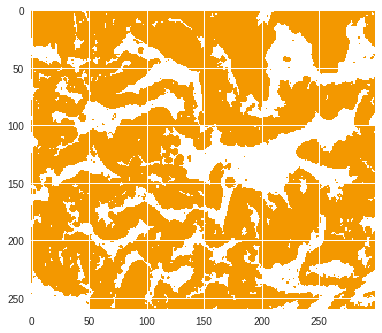

In [ ]:
plt.imshow(normal_masks[0])

In [ ]:
total_data = [data for data in iter(dataloader_WSSS4LUAD_valid)]

## Simple Class-Activation-Mapping



In [ ]:
# Return the CAM 
def return_CAM(feature_conv, weight, class_idx):
     # generate the class -activation maps upsample to 240 x 240 
     # The feature maps of the last convolutional layer, is feature conv
     # The weights have been extracted from the parameters
     # class_idx is the label of the class which has the highest probability
    size_upsample = (224, 224)
    # Conv shape should always be (1,512, 8, 8)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        # reshape to (512, 64)
        beforeDot =  feature_conv.reshape((nc, h*w))
        # (1,512) x (512,64) = (1,64)
        cam = np.matmul(weight[idx], beforeDot)
        # Reshape CAM to (8,8)
        cam = cam.reshape(h, w)
        # Upsample the cam to the size 
        #cam = cam - np.min(cam)
        #cam_img = cam / np.max(cam)
        #cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam, size_upsample))
    return output_cam


In [ ]:

# Get the models
resnet34_LUAD = model_res(torchvision.models.resnet34(pretrained=True)).to(device)
resnet34_LUAD.load_state_dict(torch.load('/content/drive/MyDrive/resnet34_224.pth')['model_state_dict'])
resnet34_LUAD.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
params = list(resnet34_LUAD.fc.parameters())
weight = np.squeeze(params[0].cpu().data.numpy())
print('weight.shape', weight.shape)

weight.shape (3, 512)


In [ ]:
def gain_feature_maps(image):
  resnet34_LUAD.eval()
  image = image.to(device)
  feature_maps = resnet34_LUAD.conv1(image)
  feature_maps = resnet34_LUAD.bn1(feature_maps)
  feature_maps = resnet34_LUAD.relu(feature_maps)
  feature_maps = resnet34_LUAD.maxpool(feature_maps)
  feature_maps = resnet34_LUAD.layer1(feature_maps)
  feature_maps = resnet34_LUAD.layer2(feature_maps)
  feature_maps = resnet34_LUAD.layer3(feature_maps)
  #feature_maps = resnet34_LUAD.layer4(feature_maps)
  return feature_maps

In [ ]:
def produce_cams_for_a_set(dataloader, weight):
  labels = list()
  all_CAMs = list()
  CAM_indexs = list()
  images = list()

  for entry in iter(dataloader):
    labels.append(entry['label'])
    images.append(entry['image'])

  for label in labels:
    index_li= list()
    nl = label.cpu().detach().numpy()[0]
    for i in range(len(nl)):
      if nl[i] == 1:
        index_li.append(i)
    CAM_indexs.append(index_li)
  
  for i in range(len(images)):
    fms = gain_feature_maps(images[i])
    CAMs_for_image = list()
    for index in CAM_indexs[i]:
      CAMs_for_image.append(return_CAM(fms.cpu().detach().numpy(), weight, [index]))
    all_CAMs.append(CAMs_for_image)

  return all_CAMs, labels




    
  






In [ ]:
all_cams_for_valid  = produce_cams_for_a_set(dataloaders['val'],weight)

ValueError: ignored

In [ ]:

scores = resnet34_LUAD(total_data[30]['image'].to(device)) # get the raw scores
probs = P.softmax(scores, dim=1).data.squeeze() # use softmax to generate the probability distribution for the scores
probs, idx = probs.sort(0, True) 
#idx = idx.cpu().numpy()

In [ ]:
mod = nn.Sequential(*list(resnet34_LUAD.children())[:-2])

In [ ]:
features_blobs = mod(total_data[30]['image'].to(device))
features_blobs1 = features_blobs.cpu().detach().numpy()
CAMs = return_CAM(features_blobs1, weight, [0])

In [ ]:
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(224, 224)), cv2.COLORMAP_JET)


error: ignored

In [ ]:
plt.imshow(heatmap)

NameError: ignored

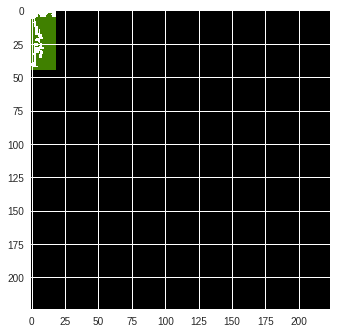

In [ ]:
plt.imshow(validation_mask_data[100])

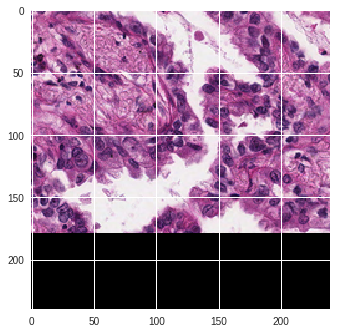

In [ ]:
imshow(total_data[100]['image'].reshape(3,240,240))

## CAPTUM



In [ ]:
integrated_gradients = IntegratedGradients(resnet34_LUAD)
attributions_ig = integrated_gradients.attribute(total_data[30]['image'].to(device), target=2, n_steps=200)


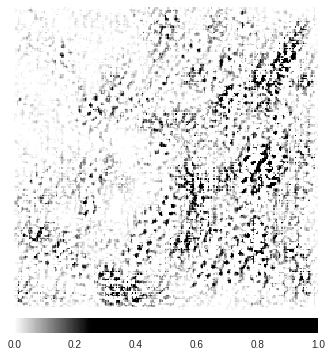

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(total_data[30]['image'].to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

## Grad-CAM

In [ ]:
resnet34_LUAD = model_res(torchvision.models.resnet34(pretrained=True)).to(device)
resnet34_LUAD.load_state_dict(torch.load('/content/drive/MyDrive/resnet34_224.pth')['model_state_dict'])
resnet34_LUAD.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Get the models

class Res34(nn.Module):
    def __init__(self):
        super(Res34, self).__init__()
        
        # get the pretrained resnet34 network
        self.resnet34_LUAD = model_res(torchvision.models.resnet34(pretrained=True)).to(device)
        self.resnet34_LUAD.load_state_dict(torch.load('/content/drive/MyDrive/resnet34_224.pth')['model_state_dict'])
        self.resnet34_LUAD.eval()
        
        # disect the network to access its last convolutional layer
        self.conv_layers = nn.Sequential(
        self.resnet34_LUAD.conv1,
        self.resnet34_LUAD.bn1,
        self.resnet34_LUAD.relu,
        self.resnet34_LUAD.maxpool,
        self.resnet34_LUAD.layer1,
        self.resnet34_LUAD.layer2,
        self.resnet34_LUAD.layer3,
        self.resnet34_LUAD.layer4
        )
          

        # get the max pool of the features stem
        self.GAP = self.resnet34_LUAD.avgpool
        
        # get the classifier of the vgg19
        self.classification = self.resnet34_LUAD.fc
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.conv_layers(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.GAP(x)
        x = x.view((1, -1))
        x = self.classification(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.conv_layers(x)


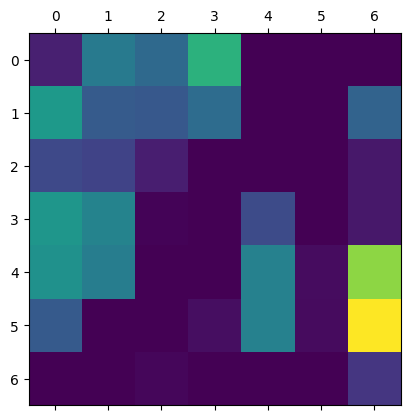

In [ ]:
# Create model, Run prediction 
plt.style.use('default')
GRAD_resnet34 = Res34()
GRAD_resnet34.eval()
example = total_data[30]
pred = GRAD_resnet34(total_data[30]['image'].to(device))

# Gain the CAM 
pred[:, 0].backward()
gradients = GRAD_resnet34.get_activations_gradient()
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = GRAD_resnet34.get_activations(total_data[30]['image'].to(device)).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

heatmap = torch.mean(activations, dim=1).squeeze()

original_heatmap = np.maximum(heatmap.cpu(), 0)



# normalize the heatmap
original_heatmap /= torch.max(original_heatmap)

# draw the heatmap
plt.matshow(original_heatmap.squeeze())

In [ ]:
plt.style.use('seaborn')

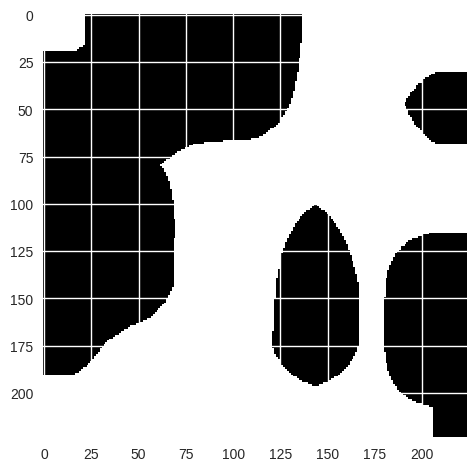

In [ ]:
heatmap = cv2.resize(original_heatmap.numpy(), (224, 224))

heatmap[heatmap>= 0.15] = 1
heatmap[heatmap < 0.15] = 0
#mask = cv2.resize(original_heatmap.numpy(), (240, 240))
plt.imshow(heatmap)

In [ ]:
# Resize images
heatmap = cv2.resize(original_heatmap.numpy(), (224, 224))
# Convert to uint8
heatmap = np.uint8(255 * heatmap)
# Warm colour heatmap
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + validation_X_data[30]

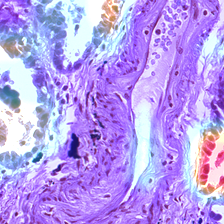

In [ ]:
cv2_imshow(superimposed_img)

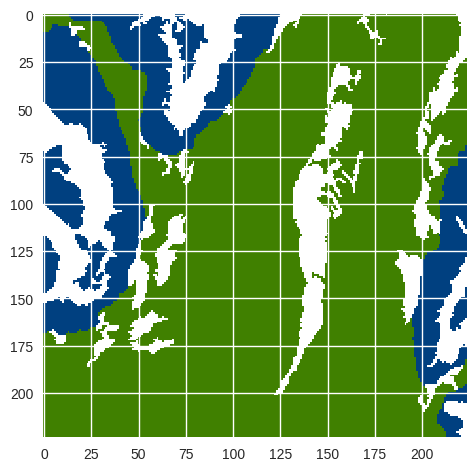

In [ ]:
plt.imshow(validation_mask_data[30])

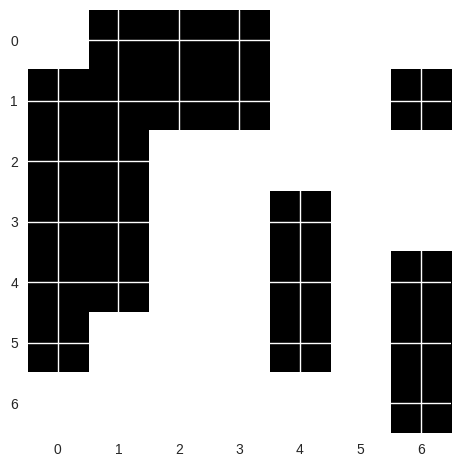

In [ ]:
# Now threshold the heatmap
original_heatmap[original_heatmap>= 0.1] = 1
original_heatmap[original_heatmap< 0.1] = 0
#mask = cv2.resize(original_heatmap.numpy(), (240, 240))
plt.imshow(original_heatmap)

## Creating a segmentation mask

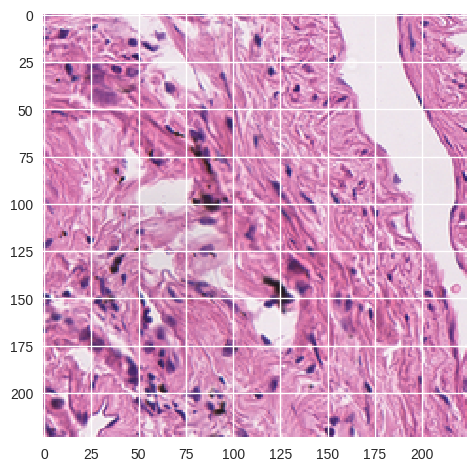

In [ ]:
plt.imshow(validation_X_data[20])

In [ ]:
def gain_class_related_heatmap(index, image, model):
  # Create model, Run prediction 
  pred = model(image.to(device))
  # Gain the CAM 
  pred[:, index].backward()
  gradients = model.get_activations_gradient()
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  # get the activations of the last convolutional layer
  activations = GRAD_resnet34.get_activations(image.to(device)).detach()
  # weight the channels by corresponding gradients
  for i in range(512):
      activations[:, i, :, :] *= pooled_gradients[i]
  heatmap = torch.mean(activations, dim=1).squeeze()
  original_heatmap = np.maximum(heatmap.cpu(), 0)
  # normalize the heatmap
  original_heatmap /= torch.max(original_heatmap)
  # draw the heatmap
  return cv2.resize(original_heatmap.numpy(), (224, 224))


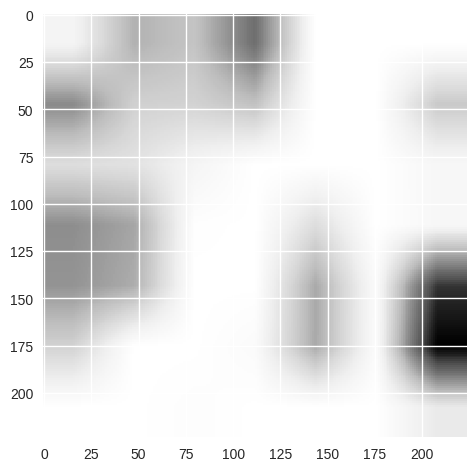

In [ ]:

GRAD_resnet34 = Res34()
GRAD_resnet34.eval()
plt.imshow(gain_class_related_heatmap(0, total_data[30]['image'], GRAD_resnet34))

In [ ]:
def gain_max_pixel(tissue_types, pixels):
 
  max_index = pixels.index(max(pixels))
  return tissue_types[max_index]



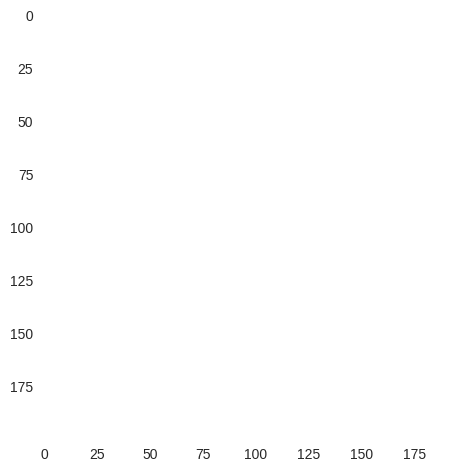

In [ ]:
img_blank = np.zeros([200,200],dtype=np.uint8)
plt.imshow(img_blank)

In [ ]:
def create_segmentation_mask(image,label, model,threshold_value):
  final_map = np.zeros((224,224,3),dtype=np.uint8)
  #print(final_map.shape)
  predicted_class_indices = [i for i in range(len(label)) if label[i] ]
  class_heatmaps = dict()
  for i in range(len(predicted_class_indices)):
    if predicted_class_indices[i] == 0:
      class_heatmaps['tumour'] = gain_class_related_heatmap(predicted_class_indices[i], image,model)
    elif predicted_class_indices[i] == 1:
      class_heatmaps['stroma'] = gain_class_related_heatmap(predicted_class_indices[i], image,model)
    elif predicted_class_indices[i] == 2:
      class_heatmaps['normal'] = gain_class_related_heatmap(predicted_class_indices[i], image,model)  
  #print(class_heatmaps['tumour'])
  all_kp = list()
  class_winners = list()
  for i in range(224):
    for j in range(224):
      key_inputs = list()
      pixel_inputs = list()
      for key, im in class_heatmaps.items():
        key_inputs.append(key)
        pixel_inputs.append(im[i][j])

      class_winner = gain_max_pixel(key_inputs,pixel_inputs)
      class_winners.append(class_winner)
      #print(str(i),  str(j))
      #print(final_map[i][j])

      if class_winner == 'tumour':
        final_map[i,j] = (0,64,128)
      elif class_winner == 'stroma':
        final_map[i,j] = (64, 128, 0)
      elif class_winner == 'normal':
        final_map[i,j] = (0, 0, 255)
  
  #print(pixel_inputs)

  return final_map 

  # Compare the heatmaps in values, we want to switch the values with the highest prediction on to the colour or turn them to 1 if that is not the case.







In [ ]:
total = (create_segmentation_mask(total_data[30]['image'],[1,1,0], GRAD_resnet34,0.1))

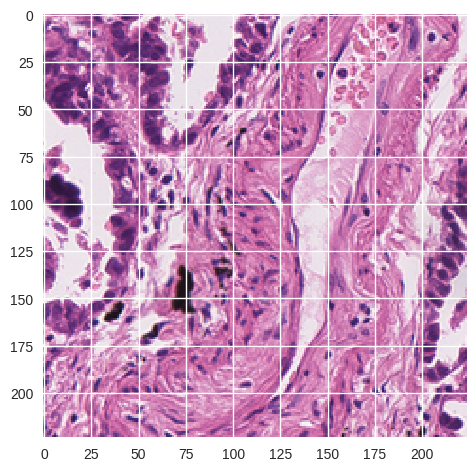

In [ ]:
plt.imshow(validation_X_data[30])

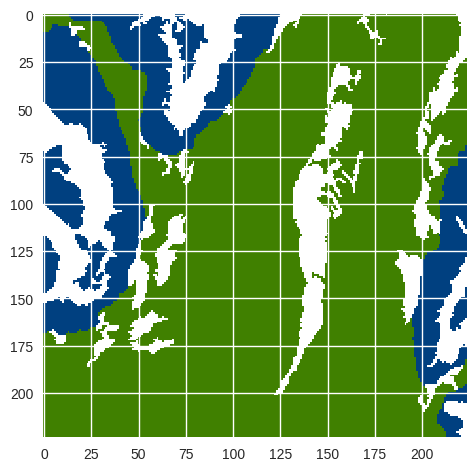

In [ ]:
plt.imshow(validation_mask_data[30])

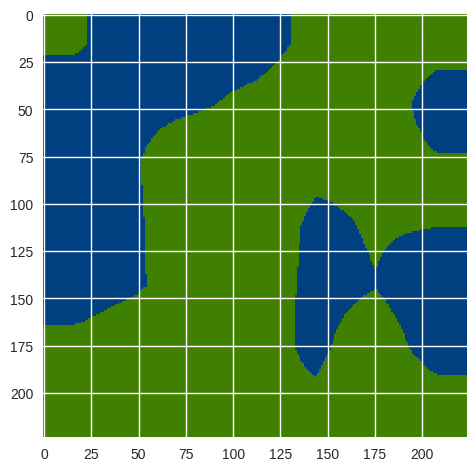

In [ ]:
plt.imshow(total)

In [ ]:
np.array(validation_X_data).shape

(1478, 224, 224, 3)

In [ ]:
np.zeros((255,255,3),np.uint8)
for i in range(224):
  for j in range(224):
    #print(validation_X_data[][i][j])
    if all(pixel>= 200 for pixel in validation_X_data[i][j]):
      total[i][j] = [255,255,255]

      

ValueError: ignored

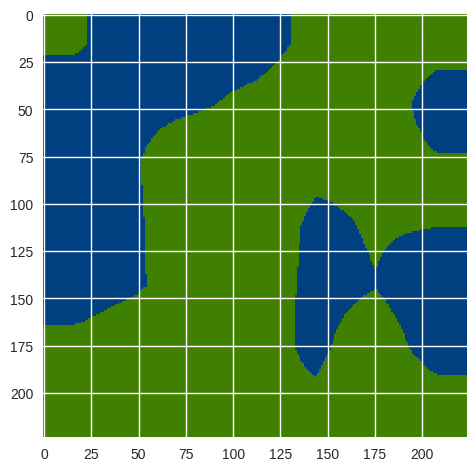

In [ ]:
plt.imshow(total)

In [ ]:
kernel = np.ones((3,3),np.uint8)

In [ ]:
opening = cv2.morphologyEx(total, cv2.MORPH_OPEN, kernel)

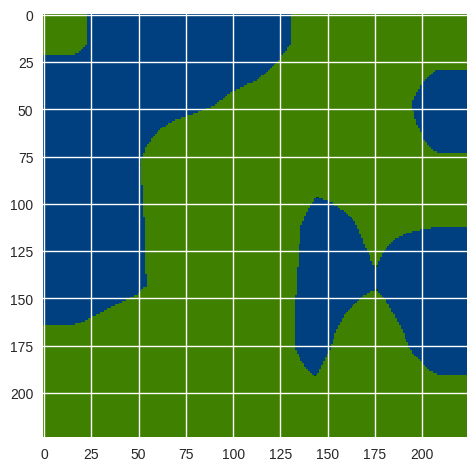

In [ ]:
plt.imshow(opening)

In [ ]:
kernel = np.ones((5,5),np.uint8)


In [ ]:
opening_2 = cv2.morphologyEx(opening, cv2.MORPH_OPEN, kernel)

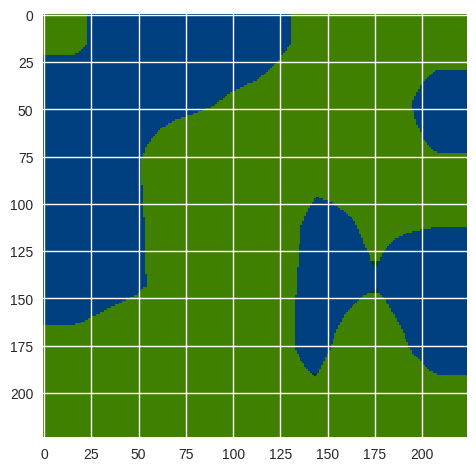

In [ ]:
plt.imshow(opening_2)

In [ ]:
background_map =  np.zeros((224,224,3),dtype=np.uint8)

for i in range(224):
  for j in range(224):
    #print(validation_X_data[30][i][j])
    if all(pixel>= 190 for pixel in validation_X_data[30][i][j]):
      background_map[i][j] = [255,255,255]
    else:
       background_map[i][j] =[0,0,0]


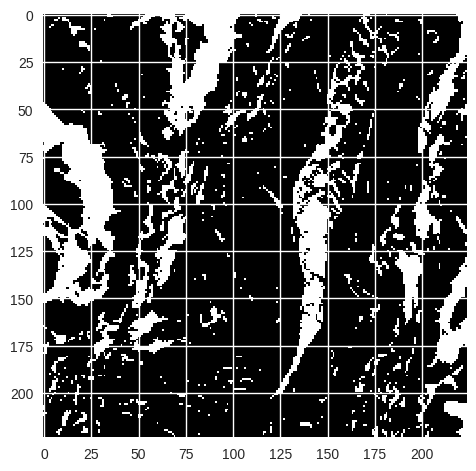

In [ ]:
plt.imshow(background_map)

In [ ]:
kernel = np.ones((3,3),np.uint8)

closing = cv2.morphologyEx(background_map, cv2.MORPH_CLOSE, kernel)


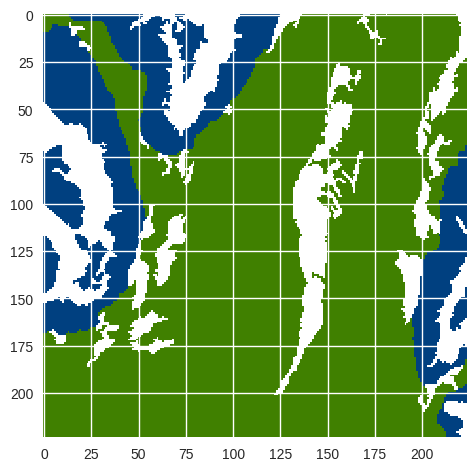

In [ ]:
plt.imshow(validation_mask_data[30])

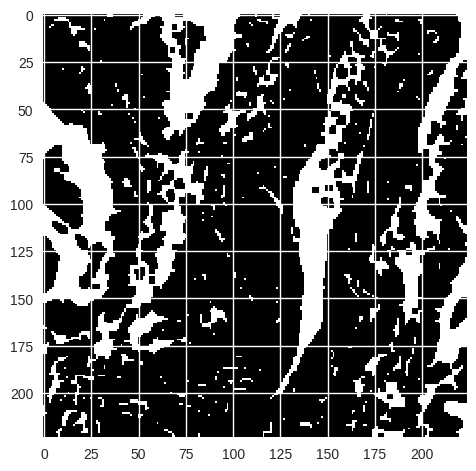

In [ ]:
plt.imshow(closing)

In [ ]:
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

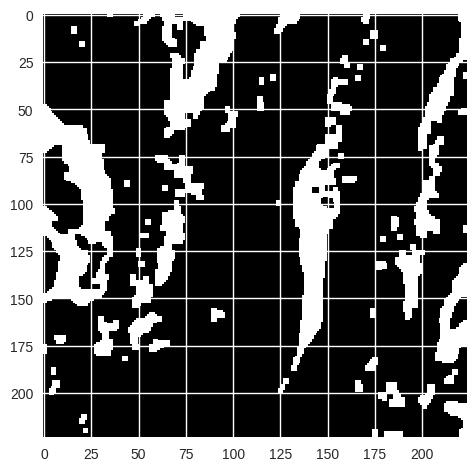

In [ ]:
plt.imshow(opening)

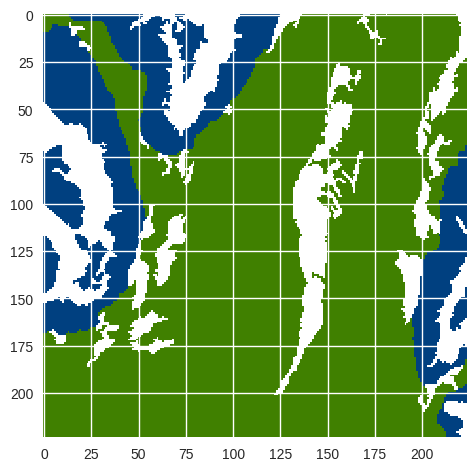

In [ ]:
plt.imshow(validation_mask_data[30])

In [ ]:
kernel = np.ones((2,2),np.uint8)


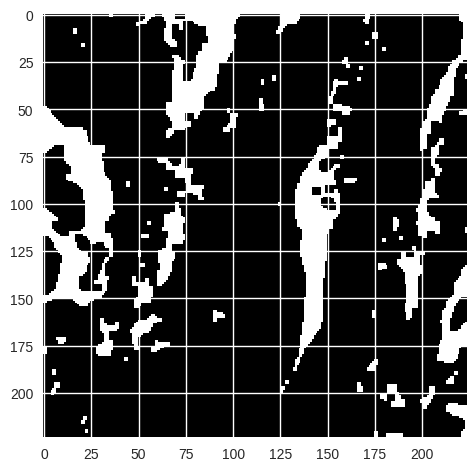

In [ ]:
final = cv2.erode(opening,kernel,iterations = 1)

plt.imshow(final)

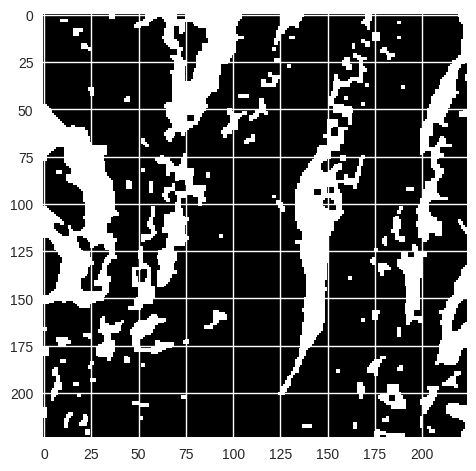

In [ ]:
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)

In [ ]:
masker = MorphologicalMasker(mpp=32)
masks = masker.fit_transform([validation_X_data[30]])

In [ ]:
from tiatoolbox.tools.tissuemask import OtsuTissueMasker


In [ ]:
masker = OtsuTissueMasker()
masker.fit([validation_X_data[30]])
masks = masker.transform([validation_X_data[30]])

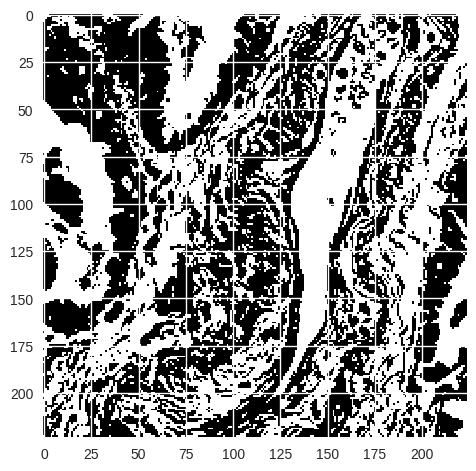

In [ ]:
plt.imshow(masks[0])

## Create Background Mask 

In [ ]:
def create_background_mask(image):
  background_map =  np.zeros((224,224,3),dtype=np.uint8)
  for i in range(224):
    for j in range(224):
      #print(validation_X_data[30][i][j])
      if all(pixel >= 190 for pixel in image[i][j]):
        background_map[i][j] = [255,255,255]
      else:
        background_map[i][j] = [0,0,0]


  kernel = np.ones((3,3),np.uint8)

  background_map = cv2.morphologyEx(background_map, cv2.MORPH_CLOSE, kernel)
  background_map = cv2.morphologyEx(background_map, cv2.MORPH_OPEN, kernel)
  kernel = np.ones((2,2),np.uint8)
  background_map = cv2.erode(background_map,kernel,iterations = 1)
  return background_map                                                                                                                                                                                          

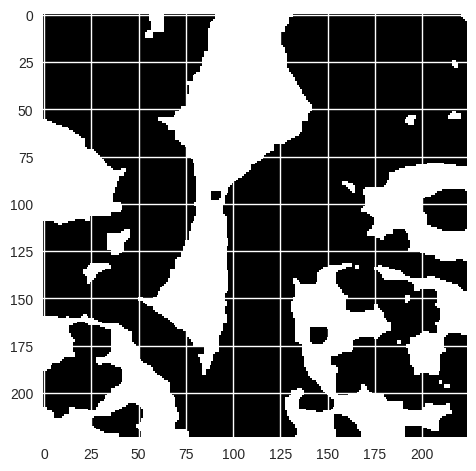

In [ ]:
plt.imshow(create_background_mask(train_X_natural_numpy[50]))

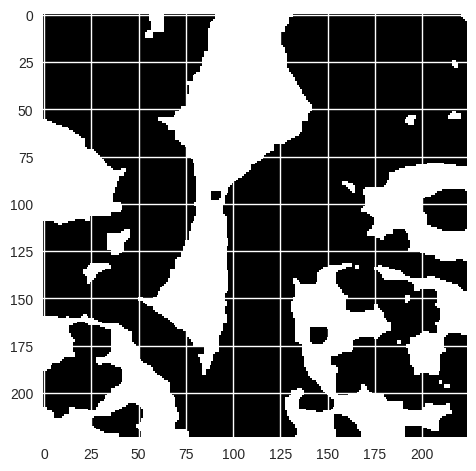

In [ ]:

plt.imshow(create_background_mask(train_X_natural_numpy[50]))

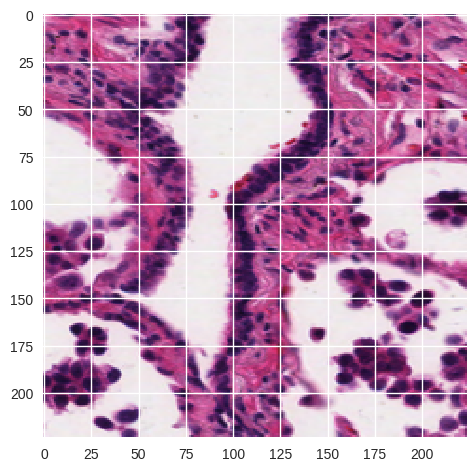

In [ ]:
plt.imshow(train_X_natural_numpy[50])

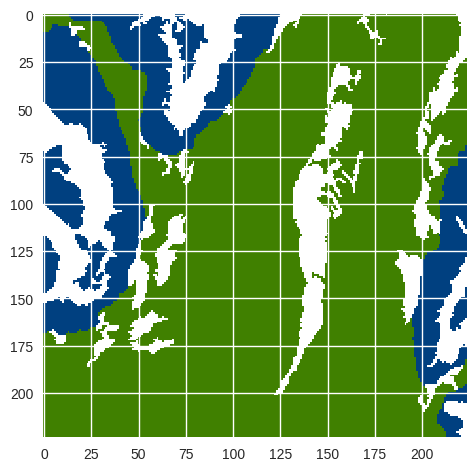

In [ ]:
plt.imshow(validation_mask_data[30])

## Creation of pseudo masks for training


In [ ]:
WSSS4LUAD_dataset_train_tomask = WSSS4LUAD_train(valid_transforms)
dataloader_train_tomask = DataLoader(dataset = WSSS4LUAD_dataset_train_tomask, batch_size = 1, shuffle = False)

In [ ]:
training_data = [item for item in iter(dataloader_train_tomask)]

In [ ]:
raw_images = list()
only_tumour_i = list()
only_tumour_i_y = list()
only_stroma_i = list()
only_stroma_i_y = list()
only_normal_i = list()
only_normal_i_y = list()
multi_class_images = list()
multi_class_images_y = list()
listing_dir = os.listdir(training_directory)
for i in range(len(listing_dir)):
   if all(training_y[i] == [1,0,0]):
      only_tumour_i.append(i)
   elif all(training_y[i] == [0,1,0]):
      only_stroma_i.append(i)
      only_stroma_i_y.append(training_y[i])
   elif all(training_y[i] == [0,0,1]):
      only_normal_i.append(i)
      only_normal_i_y.append(training_y[i])
   else:
     multi_class_images.append(i)
     multi_class_images_y.append(training_y[i])

In [ ]:
def create_background_mask(image):
  background_map =  np.zeros((224,224,3),dtype=np.uint8)
  for i in range(224):
    for j in range(224):
      #print(validation_X_data[30][i][j])
      if all(pixel >= 190 for pixel in image[i][j]):
        background_map[i][j] = [255,255,255]
      else:
        background_map[i][j] = [0,0,0]


  kernel = np.ones((3,3),np.uint8)

  background_map = cv2.morphologyEx(background_map, cv2.MORPH_CLOSE, kernel)
  background_map = cv2.morphologyEx(background_map, cv2.MORPH_OPEN, kernel)
  kernel = np.ones((2,2),np.uint8)
  background_map = cv2.erode(background_map,kernel,iterations = 1)
  return background_map                                                                                                                                                                                          

In [ ]:
def merge_background_and_colour_mask(colour_mask, background_mask):
  for i in range(224):
    for j in range(224):
      if all(pixel == 255 for pixel in background_mask[i][j]):
        colour_mask[i][j] = [255,255,255]
  return colour_mask


In [ ]:
def create_multi_class_masks(image_indexs, labels):
  multi_class_masks = list()
  for i in range (len(image_indexs)):
    color_mask = create_segmentation_mask(training_data[image_indexs[i]]['image'], labels[i], GRAD_resnet34,0.1)
    background_mask = create_background_mask(train_X_natural_numpy[image_indexs[i]])
    multi_class_masks.append(merge_background_and_colour_mask(color_mask,background_mask))
    print(i)
  return multi_class_masks

In [ ]:
bg_mask_ex = create_background_mask(validation_X_data[30])

In [ ]:
mask_ex = create_segmentation_mask(total_data[30]['image'],[1,1,0], GRAD_resnet34,0.1)

In [ ]:
masking = merge_background_and_colour_mask(mask_ex,bg_mask_ex)


In [ ]:
training_data[0]

In [ ]:
training_image_masks = create_multi_class_masks(multi_class_images,multi_class_images_y)

In [ ]:
imshow(training_data[multi_class_images[100]]['image'].reshape(3,224,224))

In [ ]:
plt.imshow(train_X_natural_numpy[multi_class_images[100]])

In [ ]:
plt.imshow(training_image_masks[100])

In [ ]:
len(multi_class_images_y)

### Save Npy

In [ ]:
for i in range(len(training_image_masks)):
  number = str(i)
  with open('/content/drive/MyDrive/CAMmasksOriginal/'+number+'.npy', 'wb') as f:
      np.save(f, training_image_masks[i])
  with open('/content/drive/MyDrive/CAMlabelOriginal'+number+'.npy', 'wb') as f:
      np.save(f, multi_class_images_y[i])
  
      

## Semantic Segmentation

In [ ]:
training_image_masks = list()
for i in range(3000):
  number = str(i)
  training_image_masks.append(np.load('/content/drive/MyDrive/CAMmasksOriginal/'+number+'.npy'))



KeyboardInterrupt: ignored

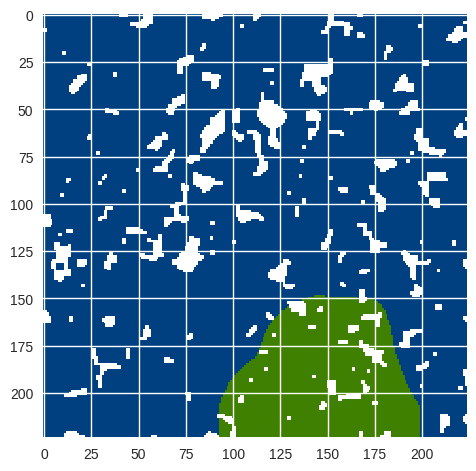

In [ ]:
plt.imshow(training_image_masks[0])

In [ ]:
plt.imshow()

In [ ]:
training_image_masks = list()
for i in range(len(multi_class_images_y)):
  print(i)
  number = str(i)
  with open('/content/drive/MyDrive/CAMmasksOriginal/'+number+'.npy', 'rb') as f:
    training_image_masks.append(np.load(f))
   



Streaming output truncated to the last 5000 lines.
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
6

### Data Amalgamation

In [ ]:
raw_images = list()
only_tumour_i = list()
only_stroma_i = list()
only_normal_i = list()
listing_dir = os.listdir(training_directory)
for i in range(len(listing_dir)):
   io=cv2.cvtColor(cv2.imread(training_directory+listing_dir[i]),cv2.COLOR_BGR2RGB)
   interp_method=PIL.Image.BICUBIC
   io = cv2.resize(io,(0,0),fx=1,fy=1, interpolation=interp_method) #resize it as specified above
   if all(training_y[i] == [1,0,0]):
      only_tumour_i.append(io)
   elif all(training_y[i] == [0,1,0]):
      only_stroma_i.append(io)
   elif all(training_y[i] == [0,0,1]):
      only_normal_i.append(io)


In [ ]:
training_image_masks[0]

array([[[  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128],
        ...,
        [  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128]],

       [[  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128],
        ...,
        [  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128]],

       [[  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128],
        ...,
        [  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128]],

       ...,

       [[  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128],
        ...,
        [  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128]],

       [[  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128],
        ...,
        [  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128]],

       [[  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128],
        ...,
        [  0,  64, 128],
        [  0,  64, 128],
        [  0,  64, 128]]

In [ ]:
training_X_seg = list()
training_y_seg = list()
training_X_seg.extend(only_normal_i)
training_y_seg.extend(normal_masks)
training_X_seg.extend(only_stroma_i)
training_y_seg.extend(stroma_masks)
training_X_seg.extend(only_tumour_i)
training_y_seg.extend(tumour_masks)



In [ ]:
for i in range(len(multi_class_images)):
  training_X_seg.append(train_X_natural_numpy[multi_class_images[i]])
  training_y_seg.append(training_image_masks[i])


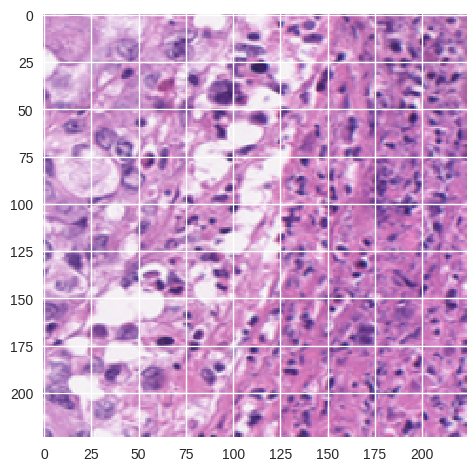

In [ ]:
plt.imshow(train_X_natural_numpy[multi_class_images[1]])

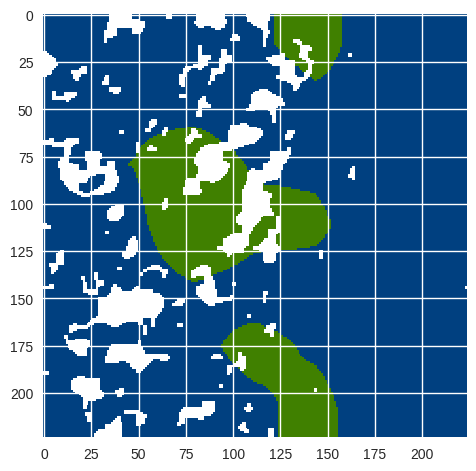

In [ ]:
plt.imshow(training_image_masks[1])


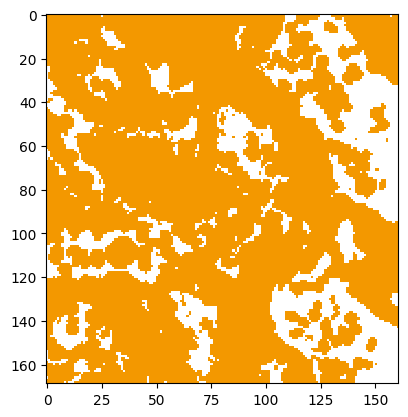

In [ ]:
plt.imshow(training_y_seg[100])

In [ ]:
plt.imshow(training_y_seg[7000])

### Mask Transformation

In [ ]:
def create_validation_masks(masks):
  new_masks = list()
  for mask in masks:
    this_mask = mask.copy()
    this_mask = this_mask[:, :,1]
    
    np.putmask(this_mask, this_mask == 0, 0)
    np.putmask(this_mask, this_mask == 255, 0)
    np.putmask(this_mask, this_mask == 64, 1)
    np.putmask(this_mask, this_mask == 128, 2)
    np.putmask(this_mask, this_mask == 152, 3)
    new_masks.append(this_mask)
  return new_masks 





In [ ]:
def create_training_masks(masks):
  new_masks = list()
  for mask in masks:
    this_mask = mask.copy()
    this_mask = this_mask[:, :, 0]

    np.putmask(this_mask, this_mask == 0, 1)
    np.putmask(this_mask, this_mask == 255, 0)
    np.putmask(this_mask, this_mask == 64, 2)
    np.putmask(this_mask, this_mask == 243, 3)
    new_masks.append(this_mask)
  return new_masks 



In [ ]:
new_masks_y = create_training_masks(training_y_seg)

In [ ]:
validation_y_masks_seg = create_validation_masks(validation_mask_data)

In [ ]:
plt.style.use('default')

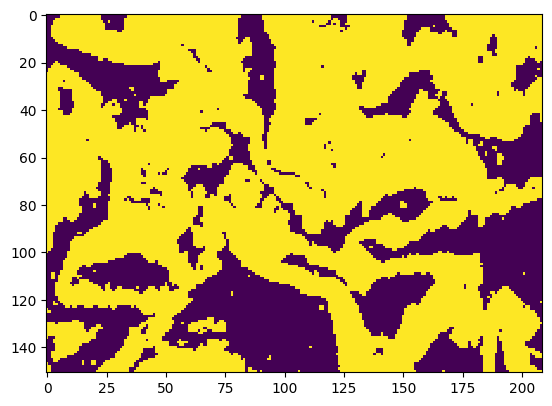

In [ ]:
plt.imshow(new_masks_y[10])

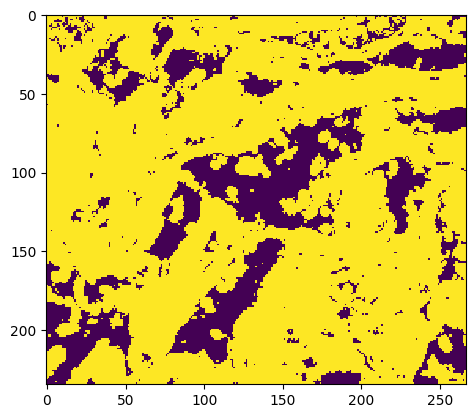

In [ ]:
plt.imshow(new_masks_y[1000])

In [ ]:
backbone = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
backbone.eval()


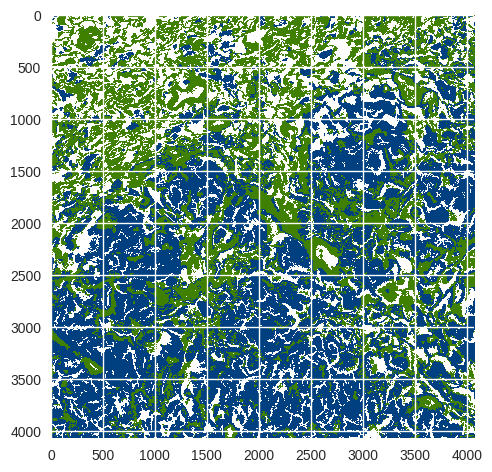

In [ ]:
plt.imshow(validation_y_seg[39])

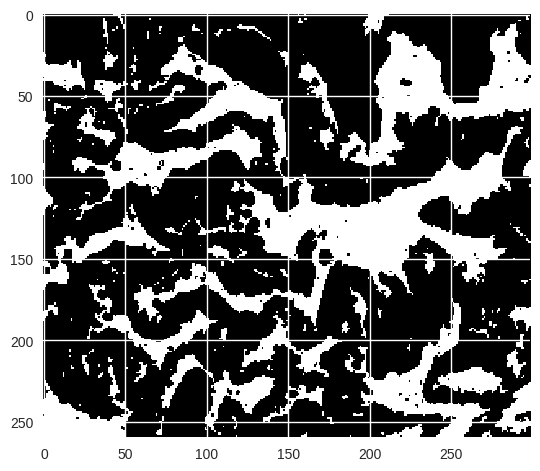

In [ ]:
plt.imshow(new_masks_y[0])

In [ ]:
seg_transform_img = transforms.Compose([
     transforms.ToPILImage(),
     transforms.ToTensor()
    ])

seg_transform_mask = transforms.Compose([
    
     
    ])


In [ ]:
training_X_seg_resized = list()
new_masks_y_resized = list()
for image in training_X_seg:
  training_X_seg_resized.append(cv2.resize(image,(224,224)))
for mask in new_masks_y:
  new_masks_y_resized.append(cv2.resize(mask,(224,224)))

In [ ]:
new_masks_y_resized

[array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 1, 3],
        ...,
        [0, 0, 0, ..., 2, 3, 3],
        [0, 0, 0, ..., 3, 3, 3],
        [0, 0, 0, ..., 3, 3, 3]], dtype=uint8), array([[3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [2, 3, 3, ..., 0, 0, 0],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3]], dtype=uint8), array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0]], dtype=uint8), array([[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 0, 1, 3]], dtype=uint8), array([[0, 0, 0, ..., 3, 3, 0],
        [0, 3, 3, ..., 3, 3, 3],
        [1, 3, 3, ..., 3, 3, 3],
 

In [ ]:
for i in range(len(training_X_seg_resized)):
  number = str(i)
  with open('/content/drive/MyDrive/Train_full/images/'+number+'.npy', 'wb') as f:
      np.save(f, training_X_seg_resized[i])
  with open('/content/drive/MyDrive/Train_full/masks/'+number+'.npy', 'wb') as f:
      np.save(f, new_masks_y_resized[i])
    

for i in range(len(validation_X_data)):
  number = str(i)
  with open('/content/drive/MyDrive/Valid_full/images/'+number+'.npy', 'wb') as f:
      np.save(f, validation_X_data[i])
  with open('/content/drive/MyDrive/Valid_full/masks/'+number+'.npy', 'wb') as f:
      np.save(f, validation_y_masks_seg[i])


In [ ]:
!unzip "/content/gdrive/MyDrive/Train_full.zip" -d "/content"


Streaming output truncated to the last 5000 lines.
  inflating: /content/Train_full/masks/2838.npy  
  inflating: /content/Train_full/images/1600.npy  
  inflating: /content/Train_full/masks/2839.npy  
  inflating: /content/Train_full/images/1400.npy  
  inflating: /content/Train_full/images/1595.npy  
  inflating: /content/Train_full/images/1598.npy  
  inflating: /content/Train_full/masks/2837.npy  
  inflating: /content/Train_full/images/1604.npy  
  inflating: /content/Train_full/images/1599.npy  
  inflating: /content/Train_full/images/1601.npy  
  inflating: /content/Train_full/images/1389.npy  
  inflating: /content/Train_full/images/1594.npy  
  inflating: /content/Train_full/masks/2834.npy  
  inflating: /content/Train_full/masks/2835.npy  
  inflating: /content/Train_full/masks/2836.npy  
  inflating: /content/Train_full/images/1597.npy  
  inflating: /content/Train_full/images/1596.npy  
  inflating: /content/Train_full/images/1390.npy  
  inflating: /content/Train_full/mask

In [ ]:
training_X_seg_resized = list()
new_masks_y_resized = list()
validation_X_data = list()
validation_y_masks_seg = list()


for i in range(len(train_X_natural_numpy)):
  number = str(i)
  print(i)
  training_X_seg_resized.append(np.load('/content/Train_full/images/'+number+'.npy'))
  new_masks_y_resized.append(np.load('/content/Train_full/masks/'+number+'.npy'))



for i in range(len(validation_data)):
  number = str(i)
  validation_X_data.append(np.load('/content/Valid_full/images/'+number+'.npy'))
  validation_y_masks_seg.append(np.load('/content/Valid_full/masks/'+number+'.npy'))


Streaming output truncated to the last 5000 lines.
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280

In [ ]:
!unzip "/content/gdrive/MyDrive/Valid_full.zip" -d "/content"


Archive:  /content/gdrive/MyDrive/Valid_full.zip
  inflating: /content/Valid_full/masks/1449.npy  
  inflating: /content/Valid_full/masks/1463.npy  
  inflating: /content/Valid_full/masks/1468.npy  
  inflating: /content/Valid_full/masks/1467.npy  
  inflating: /content/Valid_full/masks/1456.npy  
  inflating: /content/Valid_full/masks/1458.npy  
  inflating: /content/Valid_full/masks/1460.npy  
  inflating: /content/Valid_full/masks/1469.npy  
  inflating: /content/Valid_full/masks/1447.npy  
  inflating: /content/Valid_full/masks/1465.npy  
  inflating: /content/Valid_full/masks/1474.npy  
  inflating: /content/Valid_full/masks/1466.npy  
  inflating: /content/Valid_full/masks/1475.npy  
  inflating: /content/Valid_full/masks/1473.npy  
  inflating: /content/Valid_full/masks/1448.npy  
  inflating: /content/Valid_full/masks/1459.npy  
  inflating: /content/Valid_full/masks/1470.npy  
  inflating: /content/Valid_full/masks/1464.npy  
  inflating: /content/Valid_full/masks/1472.npy  
 

In [ ]:
class WSSS4LUAD_seg_train(Dataset):
  def __init__(self,img_transform, mask_transform):
    self.x = np.array(training_X_seg_resized)
    self.masks = np.array(new_masks_y_resized)
    self.n_samples =  self.x.shape[0]
    self.img_transform = img_transform
    self.mask_transform = mask_transform

  def __getitem__(self,index):
    image = self.x[index]
    mask = torch.tensor(self.masks[index])

    if self.img_transform is not None :
      random.seed(300)
      image_new = self.img_transform(image)
    

    if self.mask_transform is not None:
      random.seed(300)
      mask_new =self.mask_transform(mask)
      


    return {'image' : image_new,
            'mask' : np.array(mask_new)}

          
  
  def __len__(self):
    return self.n_samples



class WSSS4LUAD_seg_valid(Dataset):
  def __init__(self,img_transform, mask_transform):
    self.x = np.array(validation_X_data)
    self.masks = np.array(validation_y_masks_seg)
    self.n_samples =  self.x.shape[0]
    self.img_transform = img_transform 
    self.mask_transform = mask_transform

  def __getitem__(self,index):
    image = self.x[index]
    mask = torch.tensor(self.masks[index])
    if self.img_transform is not None :
      random.seed(300)
      image_new = self.img_transform(image)

    if self.mask_transform is not None:
      random.seed(300)
      mask_new =self.mask_transform(mask)
    
          

    return {'image' : image_new,
            'mask' : np.array(mask_new)}

          
  
  def __len__(self):
    return self.n_samples





In [ ]:
optim = torch.optim.Adam(backbone.parameters()) # Adam is going to be the most robust

In [ ]:
training_losses = list()
validation_loses = list()

In [ ]:
gpuid = 0


# --- unet params
# these parameters get fed directly into the UNET class, and more description of them can be discovered there
n_classes = 3    #number of classes in the data mask that we'll aim to predict
in_channels = 3  #input channel of the data, RGB = 3
padding = True   #should levels be padded
depth = 5    # depth of the network -- default of 5 for unet

wf= 2           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size = 32
patch_size = 250
num_epochs = 100 #  run it for 100 if you like
edge_weight = 1.1 # edges tend to be the most poorly segmented given how little area they 
                  # occupy in the training set, this paramter boosts their values along the lines of the original UNET paper

phases = ["train","val"] # how many phases did we create databases for?
validation_phases= ["val"] # when should we do valiation? note that validation is time consuming, @@@@@@Max: Can add train here as well
                           # so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

ignore_index = -100

In [ ]:
WSSS4LUAD_seg_train_X = WSSS4LUAD_seg_train(seg_transform_img,seg_transform_mask)
dataloader_WSSS4LUAD_train_seg = DataLoader(dataset = WSSS4LUAD_seg_train_X, batch_size = 32, shuffle = True,
)
WSSS4LUAD_seg_valid_X = WSSS4LUAD_seg_valid(seg_transform_img,seg_transform_mask)
dataloader_WSSS4LUAD_valid_seg = DataLoader(dataset = WSSS4LUAD_seg_valid_X, batch_size = 32, shuffle = False)


In [ ]:
data = next(iter(dataloader_WSSS4LUAD_valid_seg))

In [ ]:
data['image'].shape

torch.Size([32, 3, 224, 224])

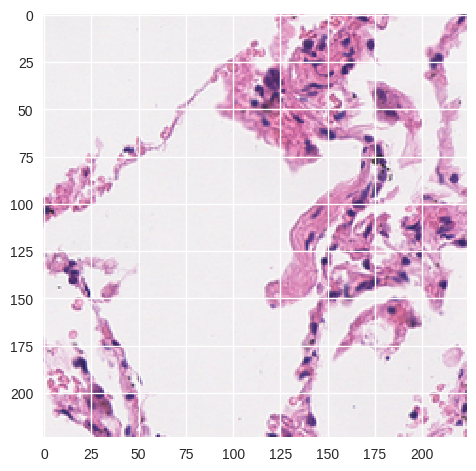

In [ ]:
imshow(WSSS4LUAD_seg_valid_X.__getitem__(0)['image'])

In [ ]:
criterion = nn.CrossEntropyLoss(reduce=False)


In [ ]:
torch.cuda.empty_cache()

In [ ]:
def seg_train (model, optimizer, criterion, learning_rate, dataloader,train_data):
  training_losses = list()
  counter = 0
  print('Training')
  best_loss_on_test = np.Infinity
  start_time = time.time()
  train_running_loss = 0.0 

  model.train()
  
  for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
    counter += 1

    X = data['image'].to(device)
    y = data['mask'].type('torch.LongTensor').to(device)


    with torch.set_grad_enabled(True):
      optimizer.zero_grad()
      #print(type(y))
      prediction = model(X)
      #print(prediction['out'])
      loss_matrix = criterion(prediction['out'],y)
      loss = loss_matrix.mean()
      train_running_loss += loss.item()
      loss.backward()
      optimizer.step()
      
    

      

  train_loss = train_running_loss/counter

  return train_loss


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
r = torch.cuda.memory_reserved(0)


In [ ]:
a = torch.cuda.memory_allocated(0)
a

7769000448

In [ ]:
train_epoch_loss

2.9962678189519085

In [ ]:
# validation function
def seg_validate(model, dataloader, criterion, val_data):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    cmatrix = np.zeros((4,4))
    
    with torch.set_grad_enabled(False):
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
          counter+=1

          X = data['image'].to(device)
          y = data['mask'].type('torch.LongTensor').to(device)
          #data, target = data['image'].to(device), data['mask'].to(device)

          # apply sigmoid activation to get all the outputs between 0 and 1
          prediction = model(X)
          #print(prediction)
          loss_matrix = criterion(prediction['out'],y)
          loss = loss_matrix.mean()
          val_running_loss += loss
          p=prediction['out'][:,:,:,:].detach().cpu().numpy()
          cpredflat=np.argmax(p,axis=1).flatten()
          yflat=y.cpu().numpy().flatten()
          cmatrix = cmatrix +confusion_matrix(yflat,cpredflat,labels=range(4))

    valid_loss = val_running_loss/counter

    return valid_loss, cmatrix 

In [ ]:
validM = seg_validate(
          backbone.to(device), dataloader_WSSS4LUAD_train_seg, criterion, WSSS4LUAD_seg_train_X
      )
      

Validating


316it [03:09,  1.66it/s]


In [ ]:
validM[1]

array([[1.96064190e+07, 4.22662000e+05, 3.42375700e+06, 3.54644490e+07],
       [1.34274770e+07, 1.00578360e+07, 2.89731120e+07, 1.25398376e+08],
       [1.16432550e+07, 2.33503800e+06, 4.84684890e+07, 1.37585500e+08],
       [4.28035100e+06, 2.15000000e+02, 3.15308200e+06, 6.20759650e+07]])

In [ ]:
# start the training and validation

def full_training_and_val_seg(backbone_model):
  #luad_model = luad_model.to(device)
  criterion = nn.CrossEntropyLoss(reduce=False)

  optimizer = torch.optim.Adam(backbone_model.parameters()) # Adam is going to be the most robust
  epochs = 5
  train_loss = []
  valid_loss = []
  valid_matrices = []
  best_loss = float('inf')
  for epoch in range(epochs):
      print(f"Epoch {epoch+1} of {epochs}")
      train_epoch_loss = seg_train(
          backbone_model, optimizer, criterion, 0.001, dataloader_WSSS4LUAD_train_seg, WSSS4LUAD_seg_train_X
      )
      valid_epoch_metrics = seg_validate(
          backbone_model, dataloader_WSSS4LUAD_valid_seg, criterion, WSSS4LUAD_seg_valid_X, 
      )

      if best_loss > valid_epoch_metrics[0]:
        best_loss = valid_epoch_metrics[0]
        torch.save({
              'epoch': epochs,
              'model_state_dict': backbone_model.state_dict(),
              'optimizer_state_dict': optim.state_dict(),
              'loss': criterion,
              }, '/content/drive/MyDrive/DEEP_Lab_1.pth')



      train_loss.append(train_epoch_loss)
      valid_loss.append(valid_epoch_metrics[0])
      valid_matrices.append(valid_epoch_metrics[1])
  
      print(f"Train Loss: {train_epoch_loss:.4f}")
      print(f'Val Loss: {valid_epoch_metrics[0]:.4f}')

  total_dict = {'training_loss' : train_loss,
                'validation_loss' : valid_loss,
                
                }
  return total_dict

In [ ]:
All_everything = full_training_and_val_seg(backbone)

Epoch 1 of 5
Training


  0%|          | 0/315 [00:00<?, ?it/s]


RuntimeError: ignored

## Inference 

In [ ]:
LUAD_semantic_segmentor = SemanticSegmentor(model=backbone, num_loader_workers=4, batch_size=32)

# define the I/O configurations for tissue segmentation model
tissue_segmentor_ioconfig = IOSegmentorConfig(
    input_resolutions=[
            {'units': 'mpp', 'resolution': 2.0}
        ],
        output_resolutions=[
            {'units': 'mpp', 'resolution': 2.0}
        ],
        
        patch_input_shape=[224, 224],
        patch_output_shape=[224, 224],
        stride_shape=[112, 112],
        save_resolution={'units': 'mpp', 'resolution': 2.0}
)